# **Understanding Vornoi Partitions using Scipy library with a graph**

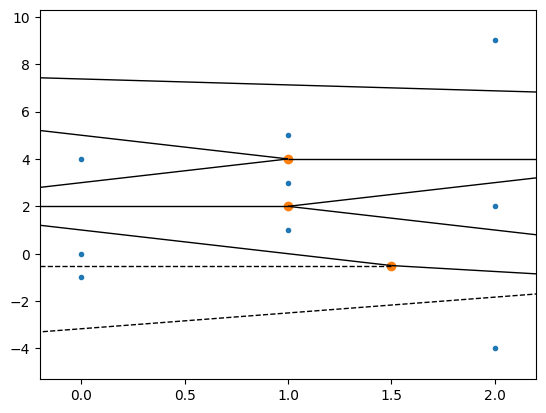

In [ ]:
import numpy as np
points = np.array([[0, 0], [0, -1], [0, 4],
 [1, 5], [1, 1], [1, 3],
  [2, 9], [2, -4], [2, 2]])
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
plt.show()

# **Understanding Vornoi Partitions with more points through a shaded graph**

<ipython-input-29-ffd12d6e952d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n)
<ipython-input-29-ffd12d6e952d>:120: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = Polygon(polygon, True)
<ipython-input-29-ffd12d6e952d>:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  p = PatchCollection(patches, cmap=plt.cm.get_cmap('tab20'), edgecolor='black')


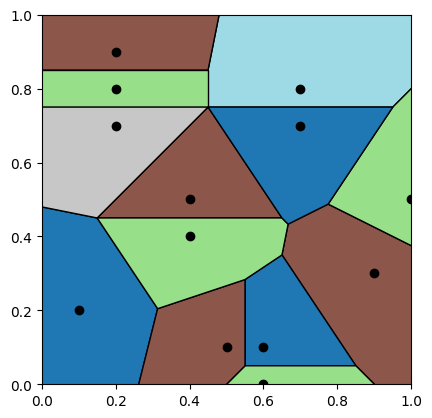

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
import networkx as nx
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Function to generate distinct colors
def get_distinct_colors(n):
    colors = plt.cm.get_cmap('tab20', n)
    return [colors(i) for i in range(n)]

# Function to get the polygon of a region, handling infinite regions
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite Voronoi regions in a 2D diagram to finite regions.
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max() * 2

    # Construct a map containing all ridges for a point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # Finite region
            new_regions.append(vertices)
            continue

        # Infinite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # Finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            far_point = vor.vertices[v2] + np.sign(np.dot(midpoint - center, n)) * n * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # Sort vertices to ensure the polygon is properly closed
        vs = np.asarray([new_vertices[i] for i in new_region])
        c = np.mean(vs, axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# Input: array of points in 2D plane
points = np.array([
    [0.1, 0.2],
    [0.4, 0.5],
    [0.7, 0.8],
    [0.9, 0.3],
    [0.2, 0.9],
    [0.6, 0.1],
    #new points
    [1.0,0.5],
    [0.2,0.8],
    [0.6,0.0],
    [0.5,0.1],
    [0.2,0.7],
    [0.4,0.4],
    [0.7,0.7],

])



# Compute Voronoi diagram
vor = Voronoi(points)

# Get finite Voronoi regions
regions, vertices = voronoi_finite_polygons_2d(vor)

# Plot the Voronoi diagram
fig, ax = plt.subplots()

# Build the adjacency graph of regions
G = nx.Graph()
for i, region in enumerate(regions):
    G.add_node(i)
    for j in range(i + 1, len(regions)):
        if len(set(region) & set(regions[j])) > 0:
            G.add_edge(i, j)

# Get a distinct color for each region
coloring = nx.coloring.greedy_color(G, strategy="largest_first")
colors = get_distinct_colors(len(set(coloring.values())))

# Create a collection of patches to color the regions
patches = []
for region_idx, region in enumerate(regions):
    polygon = vertices[region]
    polygon = Polygon(polygon, True)
    patches.append(polygon)

# Color the regions
p = PatchCollection(patches, cmap=plt.cm.get_cmap('tab20'), edgecolor='black')
p.set_array(np.array([coloring[i] for i in range(len(regions))]))
ax.add_collection(p)

# Plot the original points
ax.plot(points[:, 0], points[:, 1], 'ko')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()